In [1]:
# Cell 1: Imports and Setup

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set up plotting style
sns.set(style="whitegrid")

# Paths to the dataset
train_folder = 'cat_dog/train/train'
test_folder = 'cat_dog/test1/test1'


In [2]:
# Cell 2: Function to Load Data

def load_balanced_images_and_labels(folder, image_size=(100, 100), max_samples_per_class=100):
    images = []
    labels = []
    cat_count = 0
    dog_count = 0
    for filename in os.listdir(folder):
        if cat_count >= max_samples_per_class and dog_count >= max_samples_per_class:
            break
        if filename.startswith('cat') and cat_count < max_samples_per_class:
            labels.append(0)  # Cat label
            cat_count += 1
        elif filename.startswith('dog') and dog_count < max_samples_per_class:
            labels.append(1)  # Dog label
            dog_count += 1
        else:
            continue

        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, image_size)
            images.append(img_resized)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


Loading training data...
Training data class distribution: {0: 100, 1: 100}


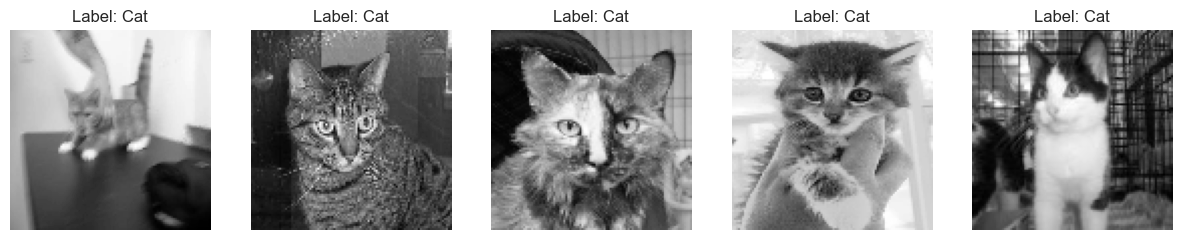

In [3]:
# Cell 3: Load and Preprocess Training Data

# Load balanced training data
print("Loading training data...")
train_images, train_labels = load_balanced_images_and_labels(train_folder)
train_images_flat = train_images.reshape(train_images.shape[0], -1)

# Print class distribution
unique, counts = np.unique(train_labels, return_counts=True)
print(f"Training data class distribution: {dict(zip(unique, counts))}")

# Visualize some training images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(f"Label: {'Cat' if train_labels[i] == 0 else 'Dog'}")
    ax.axis('off')
plt.show()


Loading test data...


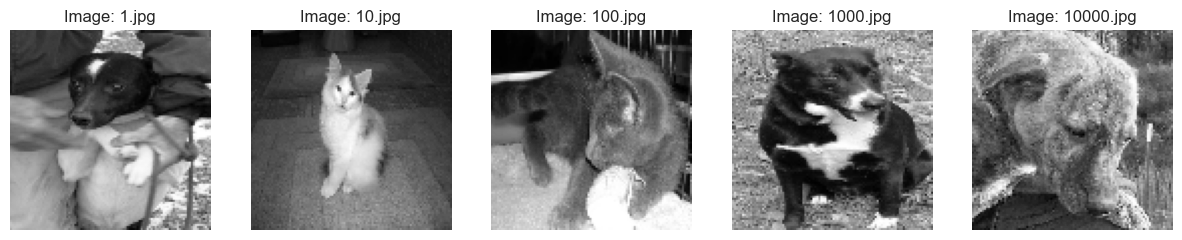

In [4]:
# Cell 4: Load and Preprocess Test Data

# Load test data
print("Loading test data...")
test_images = []
test_image_files = []
for filename in os.listdir(test_folder):
    img_path = os.path.join(test_folder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img_resized = cv2.resize(img, (100, 100))
        test_images.append(img_resized)
        test_image_files.append(filename)

test_images = np.array(test_images)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Visualize some test images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i], cmap='gray')
    ax.set_title(f"Image: {test_image_files[i]}")
    ax.axis('off')
plt.show()


In [5]:
# Cell 5: Apply PCA and Split Data

# Apply PCA for dimensionality reduction
n_components = 10
print(f"Applying PCA with {n_components} components...")
pca = PCA(n_components=n_components)
train_images_pca = pca.fit_transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images_pca, train_labels, test_size=0.2, random_state=42)


Applying PCA with 10 components...


In [6]:
# Cell 6: Hyperparameter Tuning with RandomizedSearchCV

# SVM parameters for RandomizedSearchCV
param_dist = {
    'C': [0.1, 1, 10],
    'gamma': ['scale'],
    'kernel': ['linear']
}

# Initialize SVM classifier and RandomizedSearchCV
svm = SVC()
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=3, cv=2, verbose=2, n_jobs=-1)

# Fit the model
print("Starting RandomizedSearchCV fitting process...")
random_search.fit(X_train, y_train)
print("RandomizedSearchCV fitting process completed.")

# Best model
best_svm = random_search.best_estimator_


Starting RandomizedSearchCV fitting process...
Fitting 2 folds for each of 3 candidates, totalling 6 fits
RandomizedSearchCV fitting process completed.


Validation Accuracy of the best SVM classifier: 0.68


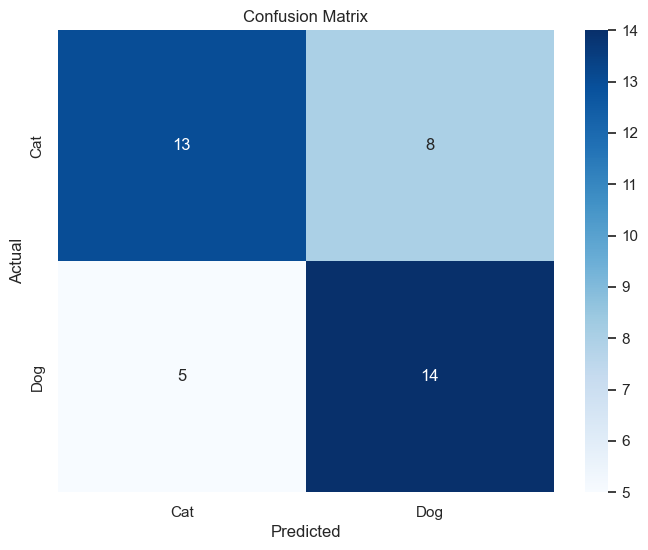

Classification Report:
              precision    recall  f1-score   support

         Cat       0.72      0.62      0.67        21
         Dog       0.64      0.74      0.68        19

    accuracy                           0.68        40
   macro avg       0.68      0.68      0.67        40
weighted avg       0.68      0.68      0.67        40



In [7]:
# Cell 7: Evaluate Model on Validation Set

# Predict on the validation set
y_val_pred = best_svm.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy of the best SVM classifier: {val_accuracy:.2f}")

# Confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_val_pred)
class_report = classification_report(y_val, y_val_pred, target_names=['Cat', 'Dog'])

# Visualization
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(class_report)
